In [9]:
import keras
import datetime
import tensorflow                       as tf
from tensorflow.keras.callbacks         import TensorBoard
from tensorflow.keras.layers            import Input, Lambda, Conv2D,Dropout,MaxPooling2D,Conv2DTranspose,concatenate,BatchNormalization, Activation,ZeroPadding2D
from tensorflow.keras.models            import Model
from tensorflow.keras.optimizers        import Adam
from keras.utils                        import plot_model
from tensorflow.keras                   import layers, models
from tensorflow.keras.losses            import mae
import sys
import os
import numpy as np
import math
import random, time

import skimage                      as ski
from   skimage.filters              import threshold_otsu
from   skimage                      import io, color
from   skimage.color                import rgb2gray
from   skimage                      import filters
import cv2                          as cv
import matplotlib.pyplot            as plt


In [10]:
# Files path
#directory= os.path.abspath("/home/guiomar/Desktop/CODES/DLCODES")
directory= os.path.abspath("/home/ppgi/Trabajo/Codigos_generate_data/DLCODES-VER-5")
# Add directory to sys.path
sys.path.append(directory)

# import script where hiperparameters are defined
import param  

# Set the number of cores
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
num_threads = param.n_threads  
tf.config.threading.set_intra_op_parallelism_threads(num_threads)

In [11]:
#Load the main directory
paths=param.list_paths 
for i,j in enumerate(paths):
    print(f'{i} => {j}')
    
# Defining amount of train,valid,test images   
n_train=param.n_train;    n_valid=param.n_valid;    n_test=param.n_test

# Defining a sample i.e.
n_sample=param.n_sample

#Pack them into batches (we’ll use batches of 10 images e.g.)
BATCH_SIZE=param.pack_size  

# For resizing dimentions everything

h=param.img_height
w=param.img_width

print(f'\nTrain = {n_train},Test = {n_test}, Valid = {n_valid}\n')
print(f'Dimensions resized h = {h}, w = {w}\n')
print(f'Pack into {BATCH_SIZE} images')

0 => /home/ppgi/Trabajo/Codigos_generate_data/DLCODES-VER-5/Geometry
1 => /home/ppgi/Trabajo/Codigos_generate_data/DLCODES-VER-5/Magnitude
2 => /home/ppgi/Trabajo/Codigos_generate_data/DLCODES-VER-5/Pression
3 => /home/ppgi/Trabajo/Codigos_generate_data/DLCODES-VER-5/U001
4 => /home/ppgi/Trabajo/Codigos_generate_data/DLCODES-VER-5/U002

Train = 0.7,Test = 0.2, Valid = 0.1

Dimensions resized h = 128, w = 256

Pack into 10 images


In [12]:
# method for reading image    
def get_img(img_name):
    return ski.io.imread(img_name)
 
# method for turning to a grey or binary image 
def processing(image,option=True):
        x = get_img(image)  
        x = rgb2gray(x)       # It returns a grayscale image with floating point values in the range from 0 to 1
        x =cv.resize(x,(w,h)) # Reshape image 
    
        # Binary option otherwise gray
        if (option):
            x=ski.util.img_as_ubyte(x)  # Convert it back to the original data type and the data range back 0 to 255. 
                                        # It is often better to use image values represented by floating point values 
            best_value_threshold=np.round(filters.threshold_otsu(x)) #  Otsu’s method calculates an “optimal” threshold
            #_,x= cv.threshold(x, best_value_threshold, 255, cv.THRESH_BINARY_INV)
            _,x= cv.threshold(x, best_value_threshold, 255, cv.THRESH_BINARY)
            x=x/255.

        x=x[:, :, np.newaxis]
        return x
    
# method for splitting data
def split_data(path,n_sample,n_train,n_valid,n_test):
        
        files=sorted([os.path.join(path, fname) for fname in os.listdir(path) if fname.endswith(".png")])
        n_files=len(files)
        
        if(n_files>n_sample):
                print('Loaded ',n_sample,'/',n_files,'**** from ',path,'\n')
                if (n_train + n_valid + n_test == 1.0):
        
                    n_train= math.floor(n_sample*n_train)
                    n_valid = math.floor(n_sample*n_valid) + n_train
                    n_test = math.floor(n_sample*n_test) + n_valid
              
                    (files_train,files_valid,files_tests) = (files[0:n_train], files[n_train:n_valid],files[n_valid:n_test])
                    
                return files_train,files_valid,files_tests

def arrays_img_processed(data,type=True): # True for Geometry 
    # begin in data[1:] 
    if type:
        list_arrays=[processing(image,option=True).astype(np.float32) for image in data[1:] ]
    else:
        list_arrays=[processing(image,option=False).astype(np.float32) for image in data[1:] ]
   
    return np.array(list_arrays) 

In [13]:
# Geometry
geo_train,geo_valid,geo_tests=split_data(paths[0],n_sample,n_train,n_valid,n_test)

geo_array_train=arrays_img_processed(geo_train)
geo_array_valid=arrays_img_processed(geo_valid)
geo_array_tests=arrays_img_processed(geo_tests)

# Magnitude
specific_tarjet=paths[1]
mag_train,mag_valid,mag_tests=split_data(specific_tarjet,n_sample,n_train,n_valid,n_test)

mag_array_train=arrays_img_processed(mag_train,False)
mag_array_valid=arrays_img_processed(mag_valid,False)
mag_array_tests=arrays_img_processed(mag_tests,False)

print(f'Training data for geometry: {geo_array_train.shape}')
print(f'Training data for magnitude: {mag_array_train.shape}\n')
print(f'Valid data for geometry: {geo_array_valid.shape}')
print(f'Valid data for magnitude: {mag_array_valid.shape}\n')
print(f'Test data for geometry: {geo_array_tests.shape}')
print(f'Test data for magnitude: {mag_array_tests.shape}\n')

print(f'geo[3][100][200] = {geo_array_train[3][100][200]}')
print(f'mag[3][100][200] = {mag_array_train[3][100][200]}')

Loaded  150 / 20001 **** from  /home/ppgi/Trabajo/Codigos_generate_data/DLCODES-VER-5/Geometry 

Loaded  150 / 20001 **** from  /home/ppgi/Trabajo/Codigos_generate_data/DLCODES-VER-5/Magnitude 

Training data for geometry: (104, 128, 256, 1)
Training data for magnitude: (104, 128, 256, 1)

Valid data for geometry: (14, 128, 256, 1)
Valid data for magnitude: (14, 128, 256, 1)

Test data for geometry: (29, 128, 256, 1)
Test data for magnitude: (29, 128, 256, 1)

geo[3][100][200] = [1.]
mag[3][100][200] = [0.16917804]


In [14]:
def plot(a1,a2,title=None,opt=None):
    if opt==None:
        fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(16, 5), sharey=True)
        ax1.set_xticks([]); ax1.set_yticks([]);
        ax2.set_xticks([]); ax2.set_yticks([]);
        ax1.imshow(a1,origin='upper',cmap='gray')
        ax1.set_title('Input',fontsize=14)
        #ax1.set_xlabel('Geometry')
        ax1.set_ylabel('Geometry',fontsize=14)
        ax2.imshow(a2,origin='upper',cmap='gray')
        ax2.set_title('Target output',fontsize=14)
        #ax2.set_xlabel('u')
        ax2.set_ylabel('u',fontsize=16)
        if title is not None: fig.suptitle(title)
    else:
        fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(16, 5), sharey=True)
        ax1.set_xticks([]); ax1.set_yticks([]);
        ax2.set_xticks([]); ax2.set_yticks([]);
        ax1.imshow(a1,origin='upper',cmap='gray')
        ax1.set_title('Real',fontsize=14)
        #ax1.set_xlabel('Geometry')
        ax1.set_ylabel('u',fontsize=14)
        ax2.imshow(a2,origin='upper',cmap='gray')
        ax2.set_title('Prediction',fontsize=14)
        #ax2.set_xlabel('u')
        ax2.set_ylabel('u',fontsize=16)
        if title is not None: fig.suptitle(title)

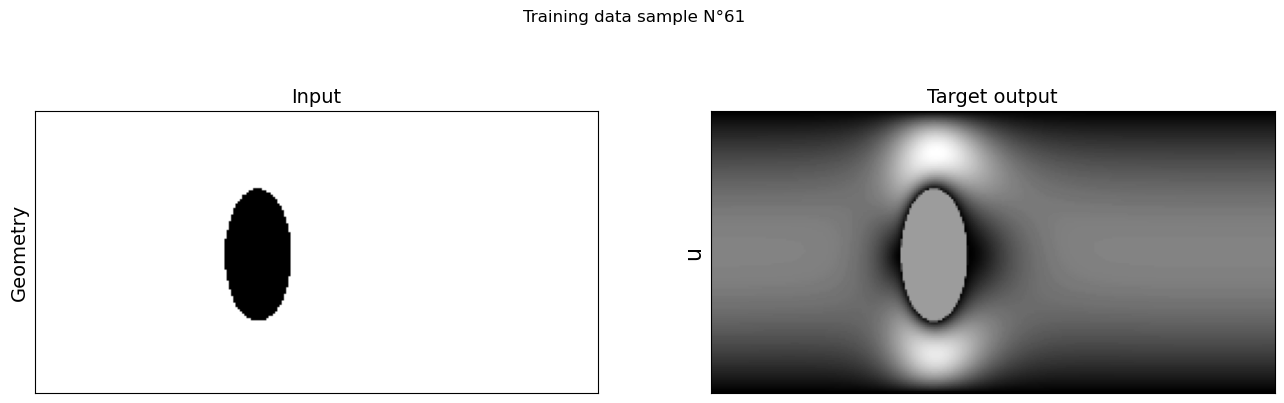

In [15]:
NUM=random.sample(range(1, geo_array_train.shape[0]), 1)
plot( geo_array_train[NUM[0]],mag_array_train[NUM[0]], title=f"Training data sample N°{NUM[0]}") 

In [17]:
geo_array_train.shape[1:]

(128, 256, 1)

In [18]:
# construct model
inputs = Input(geo_array_train.shape[1:])

# 2 3x3 convolutions followed by a max pool
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

# 2 3x3 convolutions followed by a max pool
conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

# 2 3x3 convolutions followed by a max pool
conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

# 2 3x3 convolutions followed by a max pool
conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

# 2 3x3 convolutions
conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

# 1 3x3 transpose convolution and concate conv4 on the depth dim
up6 = concatenate([ZeroPadding2D(((1,0),(1,0)))(Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5)), conv4], axis=3)




# 2 3x3 convolutions
conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

# 1 3x3 transpose convolution and concate conv3 on the depth dim
up7 = concatenate([ZeroPadding2D(((1,0),(1,0)))(Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6)), conv3], axis=3)

# 2 3x3 convolutions
conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

# 1 3x3 transpose convolution and concate conv3 on the depth dim
up8 = concatenate([ZeroPadding2D(((0,0),(1,0)))(Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7)), conv2], axis=3)

# 2 3x3 convolutions
conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

# 1 3x3 transpose convolution and concate conv3 on the depth dim
up9 = concatenate([ZeroPadding2D(((0,0),(1,0)))(Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8)), conv1], axis=3)

# 2 3x3 convolutions
conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

# final 1x1 convolutions to get to the correct depth dim (3 for 2 xy vel and 1 for pressure)
conv10 = Conv2D(3, (1, 1), activation='linear')(conv9)

# construct model
model = Model(inputs=[inputs], outputs=[conv10])

# compile the model with loss and optimizer
model.compile(loss=keras.losses.mean_squared_error,
              optimizer=keras.optimizers.Adam(lr=1e-4),
              loss=['MSE'],
              metrics=['MAE'])

# train model
model.fit(geo_array_train, mag_array_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(geo_array_tests, mag_array_tests))


"\n# 1 3x3 transpose convolution and concate conv4 on the depth dim\nup6 = concatenate([ZeroPadding2D(((1,0),(1,0)))(Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5)), conv4], axis=3)\n\n# 2 3x3 convolutions\nconv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)\nconv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)\n\n# 1 3x3 transpose convolution and concate conv3 on the depth dim\nup7 = concatenate([ZeroPadding2D(((1,0),(1,0)))(Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6)), conv3], axis=3)\n\n# 2 3x3 convolutions\nconv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)\nconv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)\n\n# 1 3x3 transpose convolution and concate conv3 on the depth dim\nup8 = concatenate([ZeroPadding2D(((0,0),(1,0)))(Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7)), conv2], axis=3)\n\n# 2 3x3 convolutions\nconv8 = Conv2D(64, (3, 3), activation='

In [ ]:
# evaluate on test set
score = model.evaluate(geo_array_tests, mag_array_tests, verbose=0)
print('Average Mean Squared Error:', score[0])

In [ ]:
# display predictions on test set
predicted_steady_flow = model.predict(test_geometries, batch_size=batch_size)
for i in xrange(predicted_steady_flow.shape[0]):
  # plot predicted vs true flow
  velocity_image = np.concatenate([predicted_steady_flow[i,:,:,0], test_steady_flows[i,:,:,0], test_geometries[i,:,:,0]/10.0], axis=1)
  plt.imshow(velocity_image)
  plt.show()
  # plot predicted vs true pressure
  velocity_image = np.concatenate([predicted_steady_flow[i,:,:,2], test_steady_flows[i,:,:,2], test_geometries[i,:,:,0]/10.0], axis=1)
  plt.imshow(velocity_image)
  plt.show()

In [ ]:
test_model = keras.models.load_model("//home/ppgi/Trabajo/Codigos_generate_data/DLCODES-VER-5/Result_01/Completed_Model.h5")
test_loss, test_acc = test_model.evaluate(geo_array_tests, mag_array_tests, verbose=0)
print(f"Test accuracy: {test_acc:.3f}")

In [1]:
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
print("GPUs disponibles:", gpus)

# Verifica si TensorFlow puede usarlas
if gpus:
    try:
        # Habilita el crecimiento de memoria (opcional)
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("✅ GPU habilitada para uso.")
    except RuntimeError as e:
        print("Error al configurar la GPU:", e)
else:
    print("❌ No se detectó GPU.")


2025-04-24 11:35:57.228504: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745508957.241203    4944 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745508957.245068    4944 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745508957.254496    4944 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745508957.254508    4944 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745508957.254510    4944 computation_placer.cc:177] computation placer alr

GPUs disponibles: []
❌ No se detectó GPU.


W0000 00:00:1745508959.042381    4944 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
